In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:

import numpy as np # linear algebra
import pandas as pd # data processing,


import os
import warnings
warnings.filterwarnings('ignore')
data_path= "../content/gdrive/My Drive/dataset2-master/images"
# Any results you write to the current directory are saved as output.

In [0]:
import cv2 
import matplotlib.pyplot as plt
from keras.preprocessing.image import *
from keras.applications import InceptionV3,VGG16
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras import layers, optimizers
from keras.models import *
import scipy
import os

In [0]:
from tqdm import tqdm
def get_data(folder):
    """
    Load the data and labels from the given folder.
    """
    X = []
    y = []
    z = []
    for wbc_type in os.listdir(folder):
        if not wbc_type.startswith('.'):
            if wbc_type in ['NEUTROPHIL']:
                label = 1
                label2 = 1
            elif wbc_type in ['EOSINOPHIL']:
                label = 2
                label2 = 1
            elif wbc_type in ['MONOCYTE']:
                label = 3  
                label2 = 0
            elif wbc_type in ['LYMPHOCYTE']:
                label = 4 
                label2 = 0
            else:
                label = 5
                label2 = 0
            for image_filename in tqdm(os.listdir(folder + wbc_type)):
                img_file = cv2.imread(folder + wbc_type + '/' + image_filename)
                if img_file is not None:
                    img_arr = np.asarray(img_file)
                    X.append(img_arr)
                    y.append(label)
                    z.append(label2)
    X = np.asarray(X)
    y = np.asarray(y)
    z = np.asarray(z)
    return X,y,z
X_train, y_train, z_train = get_data('../content/gdrive/My Drive/dataset2-master/images/TRAIN/')
X_test, y_test, z_test = get_data('../content/gdrive/My Drive/dataset2-master/images/TEST/')

# Encode labels to hot vectors (ex : 2 -> [0,0,1,0,0,0,0,0,0,0])
from keras.utils.np_utils import to_categorical
y_trainHot = to_categorical(y_train, num_classes = 5)
y_testHot = to_categorical(y_test, num_classes = 5)
z_trainHot = to_categorical(z_train, num_classes = 2)
z_testHot = to_categorical(z_test, num_classes = 2)
dict_characters = {1:'NEUTROPHIL',2:'EOSINOPHIL',3:'MONOCYTE',4:'LYMPHOCYTE'}
dict_characters2 = {0:'Mononuclear',1:'Polynuclear'}
print(dict_characters)
print(dict_characters2)

 88%|████████▊ | 1803/2051 [12:19<01:08,  3.61it/s]

In [0]:
TRAIN_PATH = data_path+'/'+'TRAIN'
TEST_PATH = data_path +'/'+'TEST'
VALID_PATH = data_path+'/'+'TEST_SIMPLE'

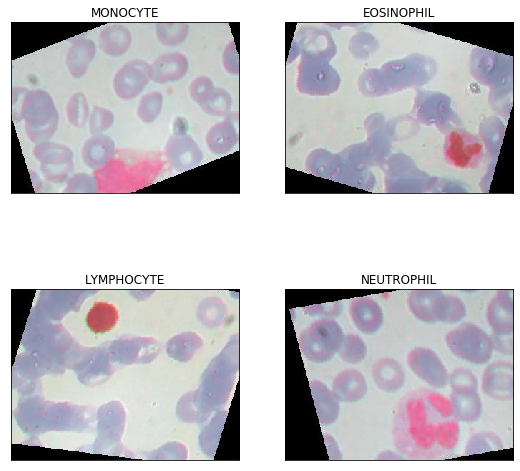

In [0]:
sample_data1_path = os.path.join(TRAIN_PATH+'/MONOCYTE','_11_3865.jpeg')
sample_data2_path = os.path.join(TRAIN_PATH+'/EOSINOPHIL','_41_6558.jpeg')
sample_data3_path = os.path.join(TRAIN_PATH+'/LYMPHOCYTE','_14_8262.jpeg')
sample_data4_path = os.path.join(TRAIN_PATH+'/NEUTROPHIL','_28_8416.jpeg')
sample_data1 = cv2.imread(sample_data1_path)
sample_data2 = cv2.imread(sample_data2_path)
sample_data3 = cv2.imread(sample_data3_path)
sample_data4 = cv2.imread(sample_data4_path)
img_shape =sample_data3.shape 
fig = plt.figure(figsize=(9,9))
ax1 = fig.add_subplot(2, 2, 1,xticks=[],yticks=[],title='MONOCYTE')
ax1.imshow(sample_data1)
ax2 = fig.add_subplot(2, 2, 2,xticks=[],yticks=[],title='EOSINOPHIL')
ax2.imshow(sample_data2)
ax3 = fig.add_subplot(2, 2, 3,xticks=[],yticks=[],title='LYMPHOCYTE')
ax3.imshow(sample_data3)
ax4 = fig.add_subplot(2, 2, 4,xticks=[],yticks=[],title='NEUTROPHIL')
ax4.imshow(sample_data4)

In [0]:
def get_model():
    base_mdoel = InceptionV3(weights='imagenet',include_top=False,input_shape=img_shape)
    model= Sequential()
    model.add(base_mdoel)
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dense(512, activation='elu'))
    model.add(layers.Dropout(0.7))
    model.add(layers.Dense(128, activation='elu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(32, activation='elu'))
    model.add(layers.Dropout(0.3))
    model.add(layers.Dense(5, activation='softmax'))
    model.summary()
    optimizer = optimizers.Adam(lr=0.0005)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['acc'])
    return model

In [0]:
def get_steps(num_samples, batch_size):
    if (num_samples % batch_size) > 0:
        return (num_samples // batch_size) + 1
    else:
        return num_samples // batch_size

In [0]:
batch_size=32
model_path = '../model/'
if not os.path.exists(model_path):
    os.mkdir(model_path)
    
model_path = model_path + 'best_model.hdf5'
train_num = X_train.shape[0]
test_num =  X_test.shape[0]

In [0]:
callbacks = [EarlyStopping(monitor = 'val_loss',verbose=1, patience = 2,mode='min'), ReduceLROnPlateau(monitor = 'val_acc',verbose=1, factor = 0.5, patience = 1, min_lr=0.00001, mode='min'),
             ModelCheckpoint(filepath=model_path,verbose=1, monitor='val_loss', save_best_only=True, mode='min'),]

In [0]:
my_inception_model =get_model()














87916544/87910968 [==============================] - 8s 0us/step
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Model)         (None, 6, 8, 2048)        21802784  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               1049088   
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               65664     
___________________________________________________________

In [0]:
history = my_inception_model.fit(
    X_train,
    y_trainHot,
    batch_size=batch_size,
    epochs=30,
    verbose=1,
    validation_data=(X_test,y_testHot),
    callbacks=callbacks)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 9957 samples, validate on 2487 samples
Epoch 1/30
9957/9957 [==============================] - 168s 17ms/step - loss: 0.5754 - acc: 0.8072 - val_loss: 1.1112 - val_acc: 0.7969

Epoch 00001: val_loss improved from inf to 1.11122, saving model to ../model/best_model.hdf5
Epoch 2/30
9957/9957 [==============================] - 142s 14ms/step - loss: 0.1662 - acc: 0.9484 - val_loss: 1.0354 - val_acc: 0.7483

Epoch 00002: val_loss improved from 1.11122 to 1.03535, saving model to ../model/best_model.hdf5
Epoch 3/30
9957/9957 [==============================] - 143s 14ms/step - loss: 0.1421 - acc: 0.9574 - val_loss: 3.1395 - val_acc: 0.6261

Epoch 00003: val_loss did not improve from 1.03535
Epoch 4/30
9957/9957 [==============================] - 142s 14ms/step - loss: 0.0873 - acc: 0.9766 - val_loss: 1.1348 - val_acc: 0.8621

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.0002

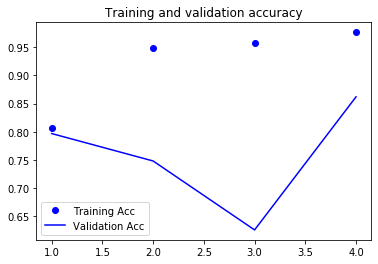

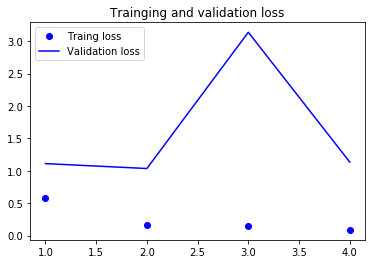

In [0]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training Acc')
plt.plot(epochs, val_acc, 'b', label='Validation Acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.show()

plt.plot(epochs, loss, 'bo', label='Traing loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Trainging and validation loss')
plt.legend()
plt.show()

In [0]:
my_inception_model.load_weights(model_path)
scores = my_inception_model.evaluate(X_test,y_testHot,verbose=1)

2487/2487 [==============================] - 10s 4ms/step


In [0]:
print("loss",scores[0],"acc:",scores[1])

loss 1.0353509885123038 acc: 0.7482911140074153
